In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2022-07-25 10:58:22.195492+02:00


# 0. import libraries, general settings

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [4]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(42)))

# 1. Read single-cell data

In [5]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('/g/arendt/npapadop/repos/coffe/data/spongilla_basic.h5ad')

In [6]:
celltype_DEG = pd.read_csv('/g/arendt/npapadop/repos/coffe/old_data/DEG_celltypes.tsv', sep='\t', decimal=',')

In [7]:
mesocytes = celltype_DEG[celltype_DEG['Cell Type'] == 'Mes1'].sort_values('Adj. Pval (BH)')

In [8]:
genes = mesocytes[:20]['Automated Gene Name (in seurat object and some suppl. Figs.)'].values

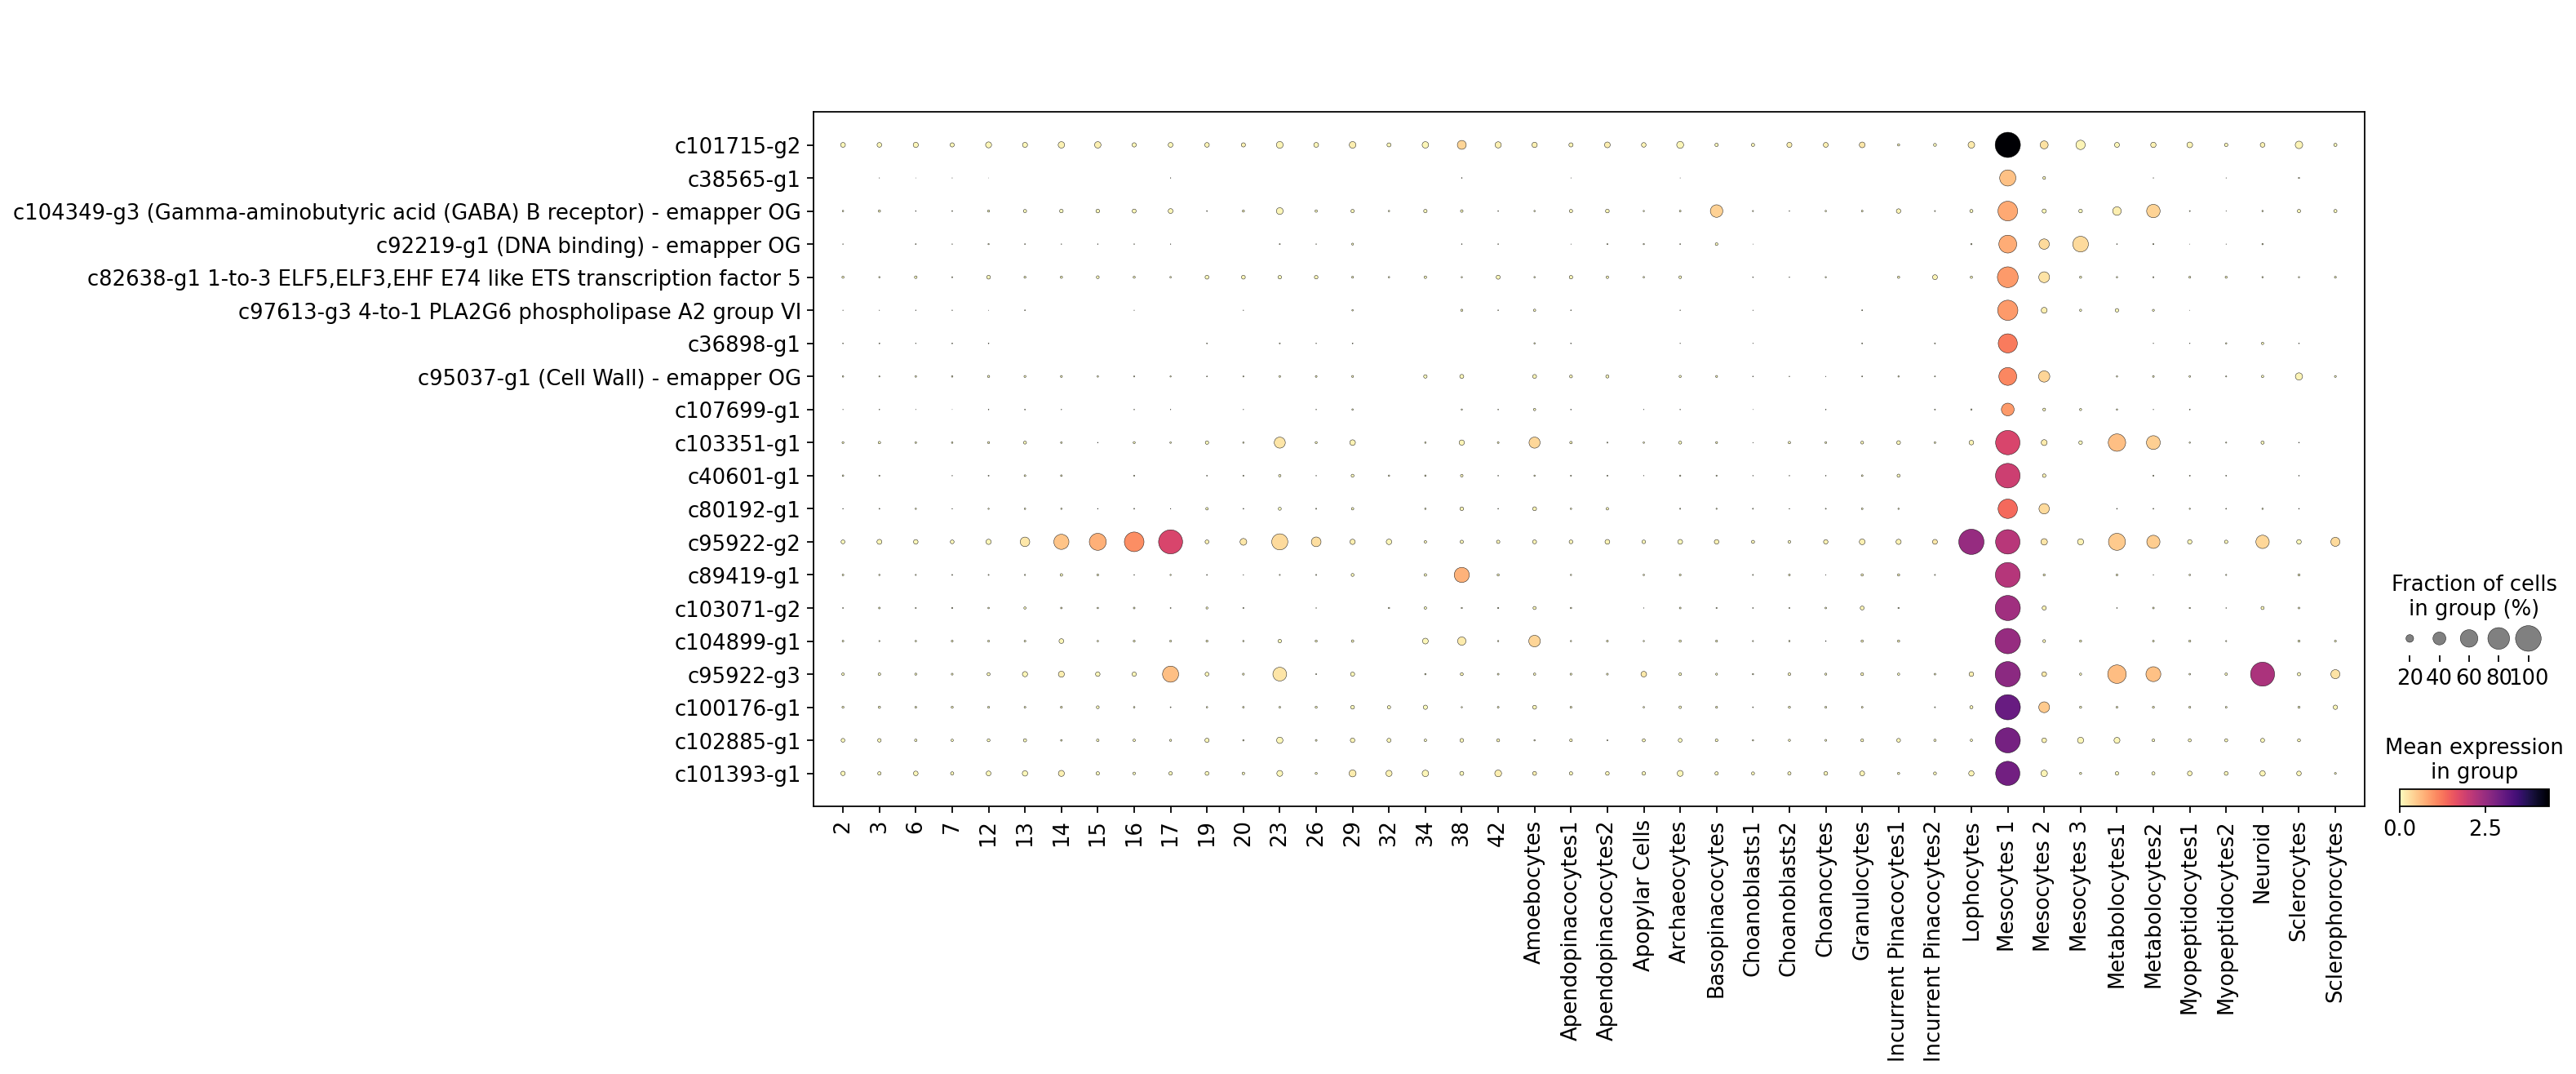

In [9]:
sc.pl.dotplot(adata, groupby='cell_type', var_names=genes, cmap='magma_r', swap_axes=True)

# 2. Set up gene annotation

In [10]:
# create a naked gene_id column to merge on
adata.var['gene_id'] = adata.var.index.str.split().str[0].str.replace('-', '_')
adata.var['legacy name'] = adata.var.index.values
adata.var.set_index('gene_id', inplace=True)
# read foldseek annotation and keep relevant columns
annot = pd.read_csv("/g/arendt/npapadop/repos/coffe/old_data/spongilla_lut.tsv", sep='\t')
annot_nodoubl = annot.sort_values('bit score', ascending=False).drop_duplicates('gene_id')
keep = ['gene_id', 'Preferred_name_seq', 'Preferred_name_struct', 'Description_seq', 'Description_struct', 'Function [CC]', 'PFAMs_seq', 'PFAMs_struct']
annot_nodoubl = annot_nodoubl[keep]
adata.var = adata.var.join(annot_nodoubl.set_index('gene_id'), how='left')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


To facilitate marker gene plotting but also counting the number of annotated genes we will create new columns in the `.var` slot that will hold the sequence based names, structure based names, and combinations thereof, which will be the most comprehensive.

First we'll start by finding the different annotation levels - named genes, described genes, and unannotated genes - both for sequence-based and structure-based annotation.

In [11]:
seq_isnan = adata.var["Preferred_name_seq"].isnull()
seq_missing = adata.var["Preferred_name_seq"] == "-"
seq_no_desc = adata.var["Description_seq"].isnull()
seq_desc_mis = adata.var["Description_seq"] == "-"

struct_isnan = adata.var["Preferred_name_struct"].isnull()
struct_missing = adata.var["Preferred_name_struct"] == "-"
struct_no_desc = adata.var["Description_struct"].isnull()
struct_desc_mis = adata.var["Description_struct"] == "-"

seq_has_name = ~(seq_isnan | seq_missing)
seq_has_desc = ~(seq_no_desc | seq_desc_mis)
struct_has_name = ~(struct_isnan | struct_missing)
struct_has_desc = ~(struct_no_desc | struct_desc_mis)

In [12]:
adata.var['gene_id'] = adata.var.index.values

Now we will combine the masks to build the best sequence annotation by using the gene IDs and the emapper fields

In [13]:
# build best sequence annotation
has_seq_desc_but_no_seq_name = seq_has_desc & ~seq_has_name
seq_unannotated = ~(seq_has_name | has_seq_desc_but_no_seq_name)
seq_named = adata.var["gene_id"][seq_has_name] + " | " + "[" + adata.var["Preferred_name_seq"][seq_has_name] + "]"
seq_described = adata.var["gene_id"][has_seq_desc_but_no_seq_name] + " | [" + adata.var["Description_seq"][has_seq_desc_but_no_seq_name] +"]"
seq_unnamed = adata.var["gene_id"][seq_unannotated]
seq_names = pd.DataFrame(seq_named.append(seq_described).append(seq_unnamed))
seq_names.columns = ['best seq. name']

same for structure-based annotation

In [14]:
# build best structure annotation
has_struct_desc_but_no_struct_name = struct_has_desc & ~struct_has_name
struct_unannotated = ~(struct_has_name | has_struct_desc_but_no_struct_name)
struct_named = adata.var["gene_id"][struct_has_name] + " | (" + adata.var["Preferred_name_struct"][struct_has_name] + ')'
struct_described = adata.var["gene_id"][has_struct_desc_but_no_struct_name] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_struct_name] + ")"
struct_unnamed = adata.var["gene_id"][struct_unannotated]
struct_names = pd.DataFrame(struct_named.append(struct_described).append(struct_unnamed))
struct_names.columns = ['best struct. name']

Very similarly, we will combine the masks to make the best combination. We will always give precedence to sequence-based annotation, wherever available.

In [15]:
# best overall annotation
# first sequence name, then sequence description
# then structure name, then structure description
has_struct_name_but_no_seq_any = seq_unannotated & struct_has_name
has_struct_desc_but_no_else = seq_unannotated & ~struct_has_name & struct_has_desc
unannotated = ~(seq_has_name | seq_has_desc | struct_has_name | struct_has_desc)

struct_named_no_seq = adata.var["gene_id"][has_struct_name_but_no_seq_any] + " | (" + adata.var["Preferred_name_struct"][has_struct_name_but_no_seq_any] + ")"
struct_desc_nothing_else = adata.var["gene_id"][has_struct_desc_but_no_else] + " | (" + adata.var["Description_struct"][has_struct_desc_but_no_else] + ")"
unnamed = adata.var["gene_id"][unannotated]

best_names = pd.DataFrame(seq_named.append(seq_described).append(struct_named_no_seq).append(struct_desc_nothing_else).append(unnamed))
best_names.columns = ['best name']

Actuall add the annotation to the object:

In [16]:
adata.var = adata.var.join(seq_names)
adata.var = adata.var.join(struct_names)
adata.var = adata.var.join(best_names)

In [17]:
adata.var.drop('gene_id', inplace=True, axis=1)

In [18]:
mesocytes['gene_id'] = mesocytes['Automated Gene Name (in seurat object and some suppl. Figs.)'].str.split().str[0].str.replace('-', '_')
mesocytes = mesocytes.merge(seq_names, on='gene_id').merge(struct_names, on='gene_id').merge(best_names, on='gene_id')

In [23]:
genes = mesocytes[:20]['best name'].values

... storing 'Preferred_name_seq' as categorical
... storing 'Preferred_name_struct' as categorical
... storing 'Description_seq' as categorical
... storing 'Description_struct' as categorical
... storing 'Function [CC]' as categorical
... storing 'PFAMs_seq' as categorical
... storing 'PFAMs_struct' as categorical


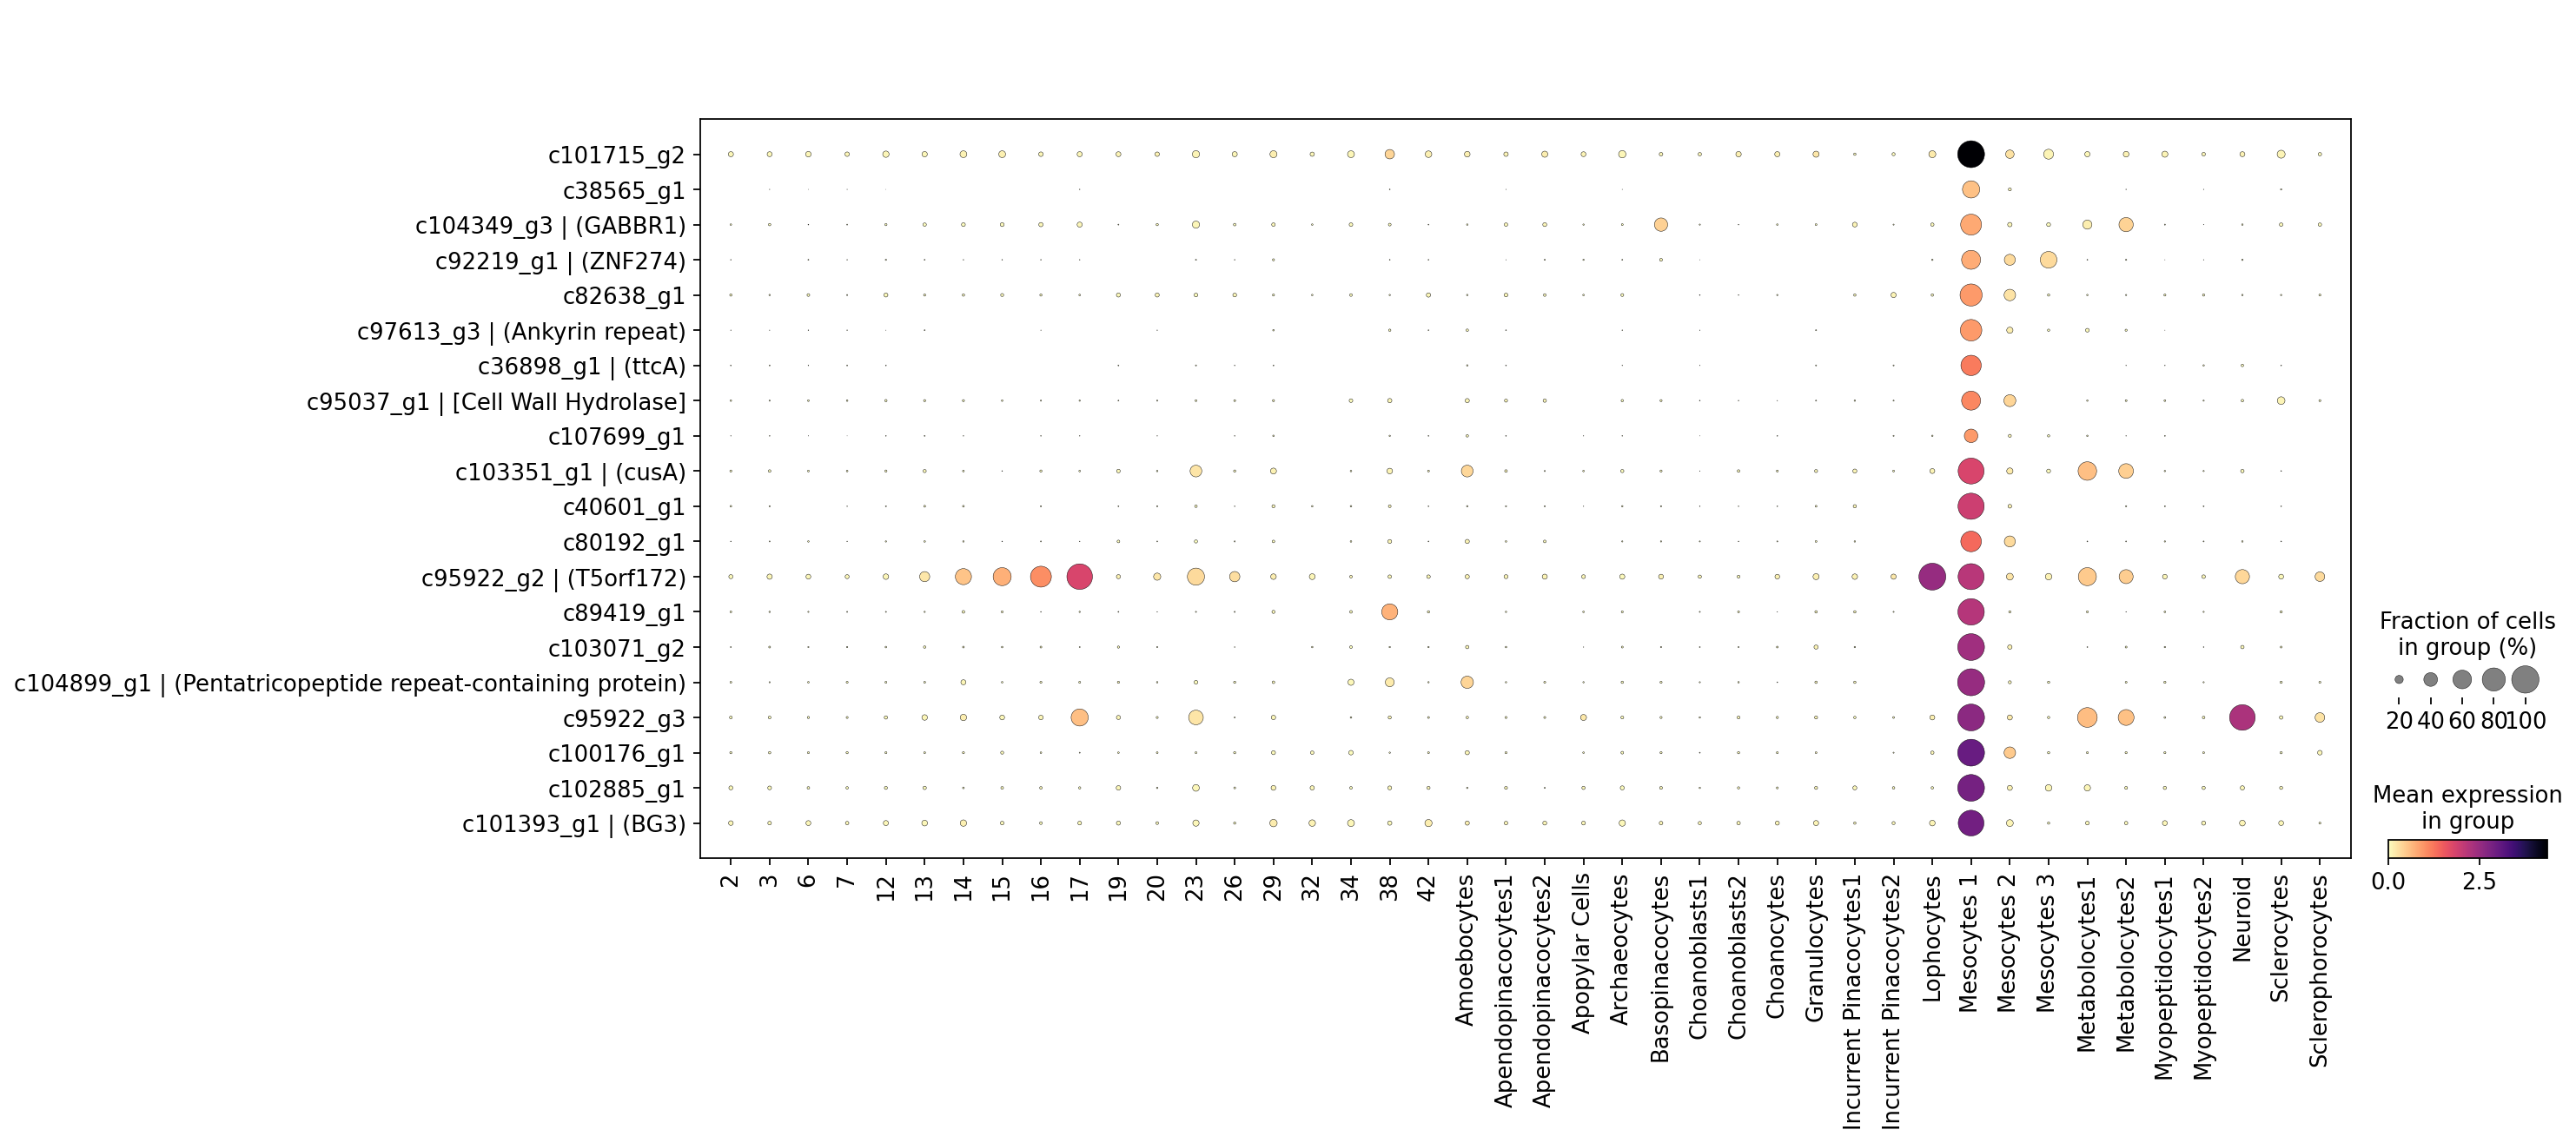

In [21]:
sc.pl.dotplot(adata, groupby='cell_type', var_names=genes, gene_symbols='best name', cmap='magma_r', swap_axes=True)

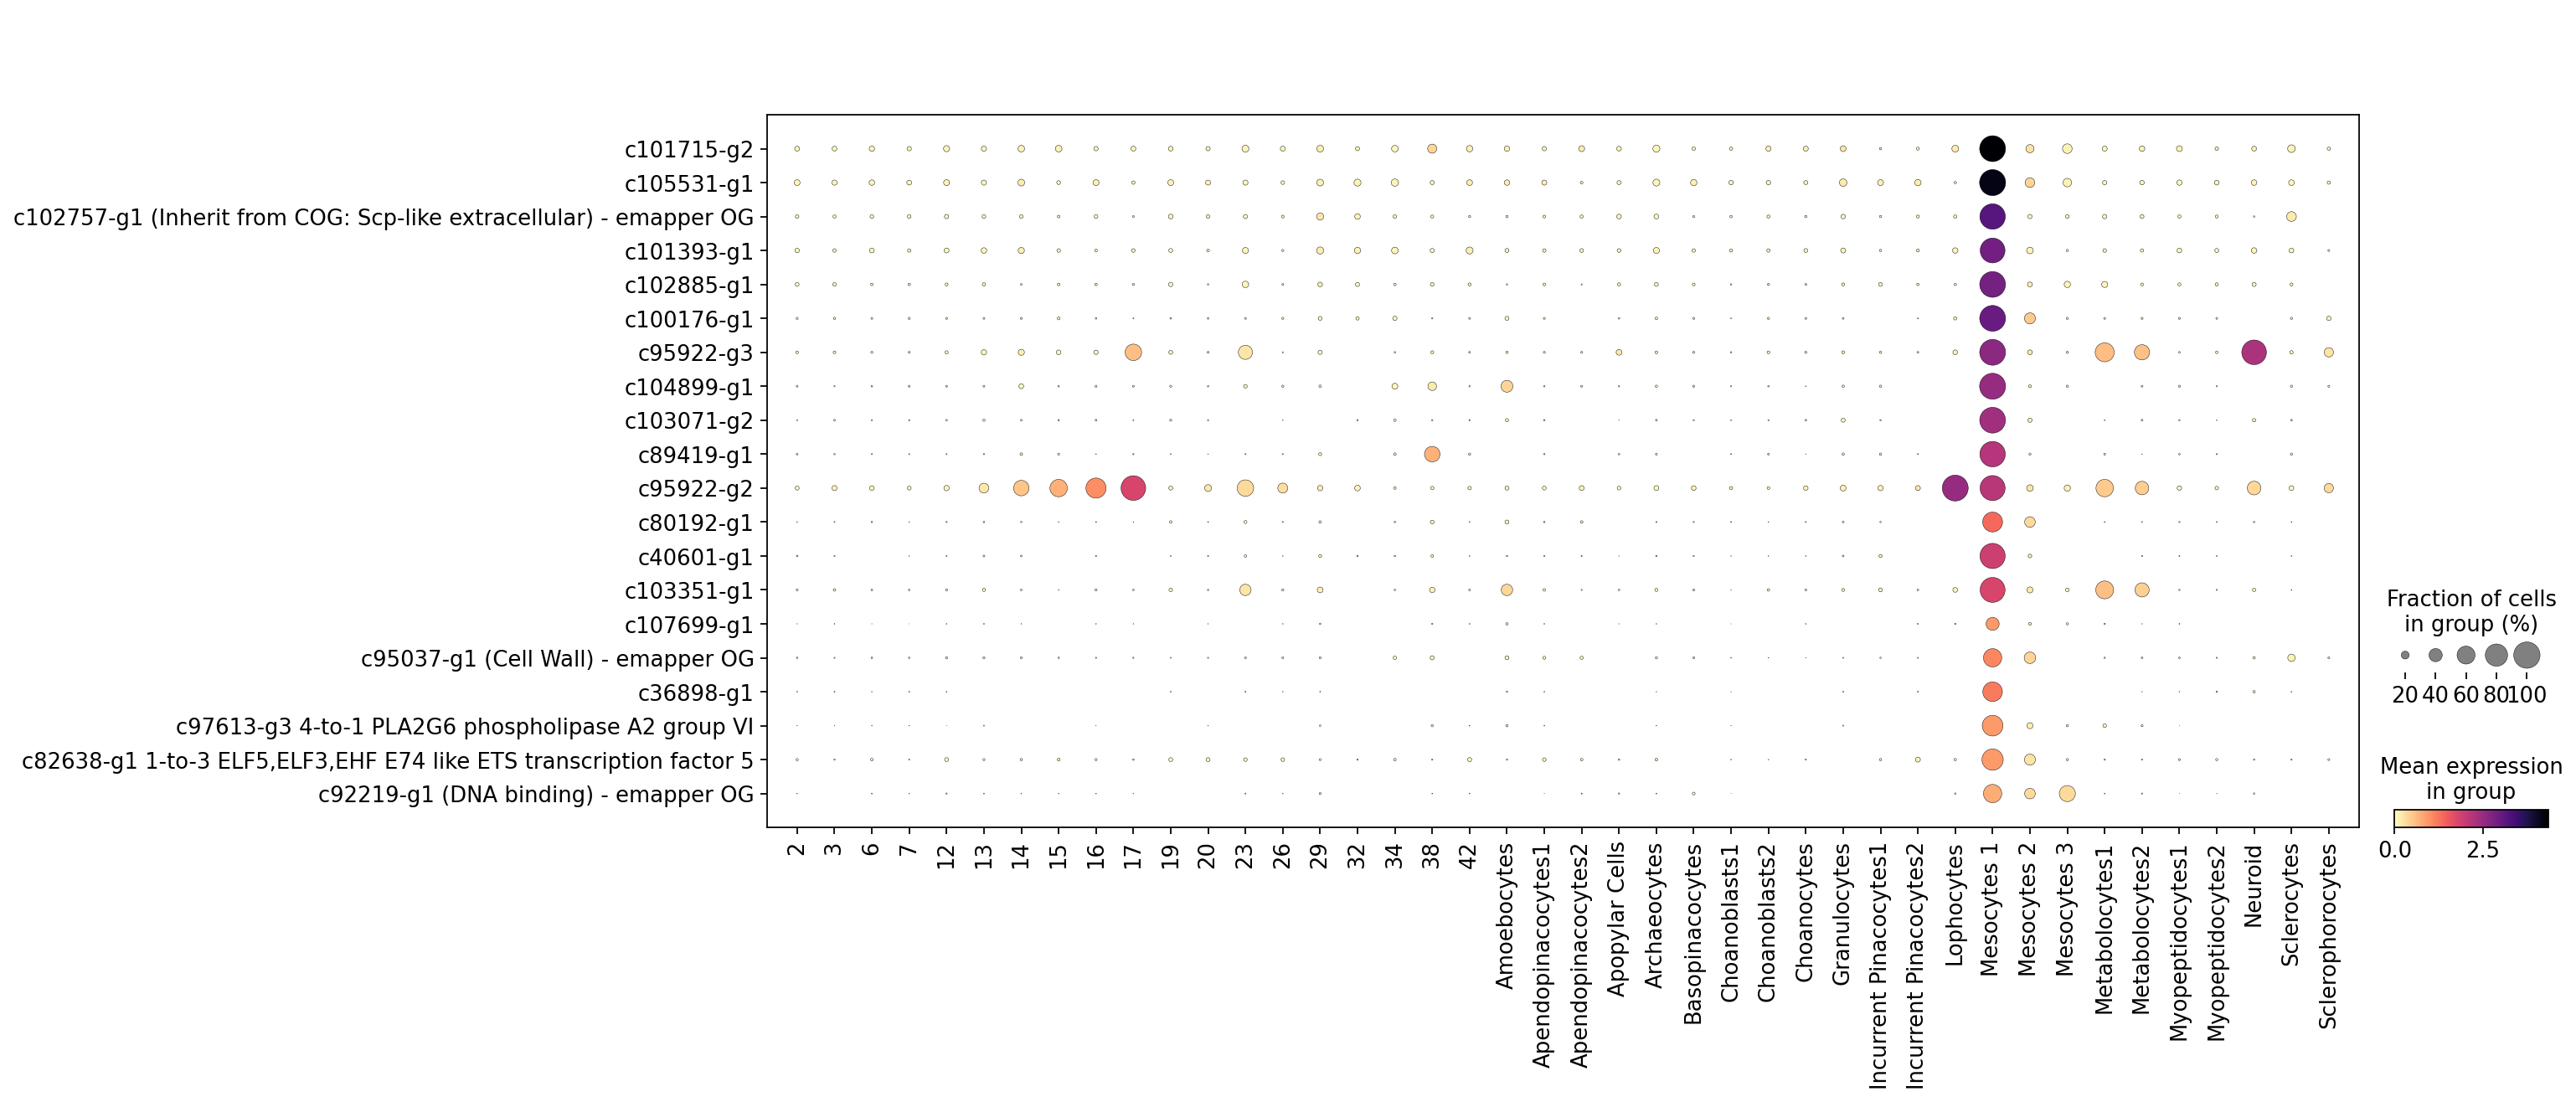

In [8]:
sc.pl.dotplot(adata, groupby='cell_type', var_names=genes, cmap='magma_r', swap_axes=True)

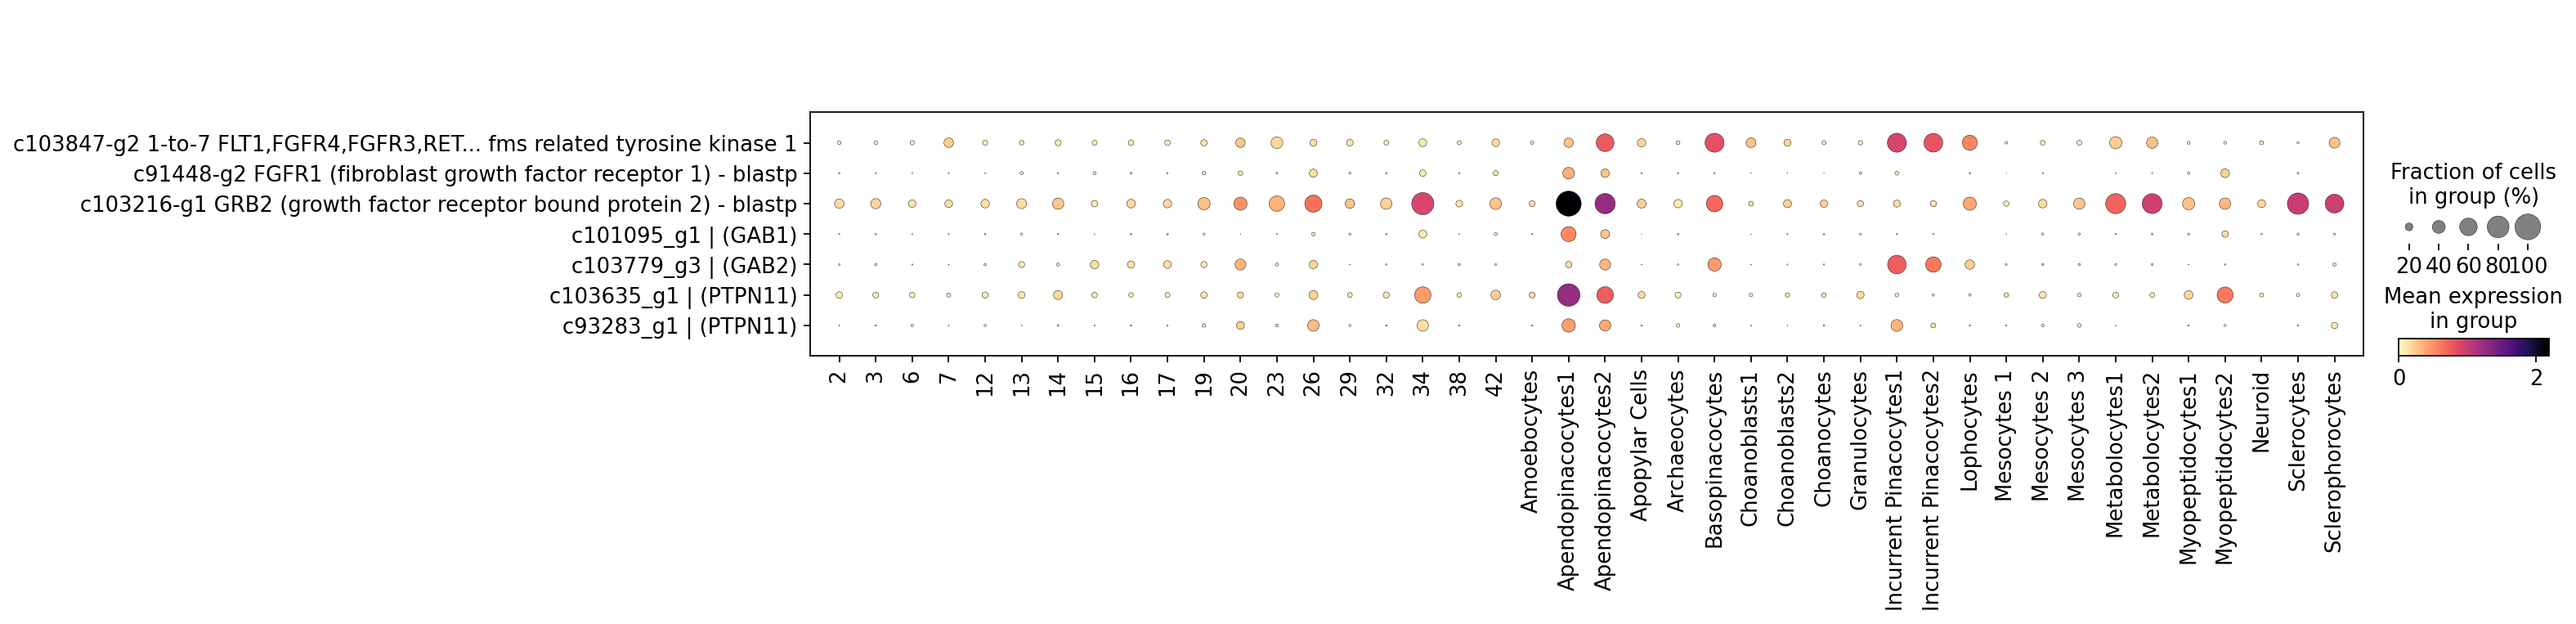

In [97]:
# FGFR/GRB/GAB/PTPN signalling cascade
ptpn = ['c103635_g1', 'c93283_g1']
grb = ['c103216_g1']
fgfr = ['c103847_g2', 'c91448_g2']
gab = ['c101095_g1', 'c103779_g3']

sc.pl.dotplot(adata, groupby='cell_type', var_names=adata.var['fusion'][fgfr + grb + gab + ptpn], gene_symbols='fusion', cmap='magma_r', swap_axes=True)